<div dir="rtl">
    
# المعالجة المسبقة لبيانات WaPOR باستخدام بيثون

</div>
<div dir="rtl">
يحتوي هذا الدفتر على خطوات للمعالجة المسبقة لبيانات WaPOR
</div>

<div dir="rtl">

- [1. اقتصاص امتداد](#Step-1.-Crop-to-Extent)
- [2. إعادة القياس باستخدام البيانات الوصفية](#Step-2.-Rescale-using-metadata)
- [3. تجميع البيانات الشهرية](#Step-3.-Aggregate-monthly-data)
- [4. تجميع البيانات في فترة](#Step-4.-Aggregate-data-in-a-period)
- [5. التفاف البيانات النقطية](#Step-5.-Warp-raster-data)
- [6. عمل مقطع إلى ملف الشكل cutline](#Step-6.-Clip-to-Shapefile-cutline)

</div>

<div dir="rtl">
في كل خطوة، ستجد أمثلة على أكواد وتمارين لتطبيق المثالفي كل خطوة، ستجد أمثلة على أكواد وتمارين لتطبيق المثال
</div>
<div dir="rtl">
أولاً، قم باستيراد مكتبات / حزم بحيث يمكن استخدام الوظائف من هذه المكتبات. 
</div>

In [1]:
import os
import shapefile
import glob
import gdal
import osgeo
import hkvwaporpy as hkv
import osr
import ogr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Step 1. Crop to Extent
<div dir="rtl"> 
الخطوة 1. اقتصاص إلى مدى
</div>
<div dir="rtl">
    
### مثال
    
</div>

<div dir="rtl">      
لاقتصاص تعيين الخريطة النقطية إلى حد ما ، يلزم وجود ملف شكل أو إحداثيات المدى. على سبيل المثال ، تم إعداد ملف أشكال لحوض Awash في البيانات
مجلد data. يوضح الكود أدناه كيفية الحصول على
وجود حوض الاواش. أولاً ، اقرأ ملف bbox الخاص بملف الأشكال المحدد للمنطقة محل الاهتمام.    
</div>

[مجلد البيانات](data)

In [2]:
tg_shp= r".\data\Awash_shapefile.shp"
shape = shapefile.Reader(tg_shp)
shape.bbox

[37.95883206252312, 7.89534, 43.32093, 12.3873979377346]

<div dir="rtl">
يعرض شكل shape.bbox إحداثيات المربع المنضم لملف الشكل وهي xmin (أدنى خط طول) و ymin (أدنى خط عرض) و xmax (أعلى خط طول) و ymax (أعلى خط عرض). سيمرر الكود أدناه هذه القيم الأربع إلى المتغيرات الأربعة ذات الصلة
</div>

In [3]:
extent=shape.bbox
xmin,ymin,xmax,ymax=extent[0],extent[1],extent[2],extent[3]
xmin,ymin,xmax,ymax

(37.95883206252312, 7.89534, 43.32093, 12.3873979377346)

<div dir="rtl">    
بعد ذلك ، سوف نحصل على قائمة بالملف النقطي الذي نحتاج إلى اقتصاصه. للحصول على قائمة بجميع معالجات الملفات في مجلد ، يمكننا استخدام وحدة glob على النحو التالي. يحتوي متغير معالج الملفات على مسار إلى أي ملف .tif نقطي في مجلد الإدخال ، حيث يتم استبدال الحرف * باسم الملف. طول قائمة input_fhs هو عدد الملفات في مجلد الإدخال. إذا تم تنزيل بيانات L1_PCP_E بنجاح من دفتر الملاحظات السابق  التمرين 1 ، يجب أن يكون عدد الملفات 365 عند تشغيل خلية الرمز.     
</div>

[ دفتر الملاحظات السابق  التمرين 1](1_Download_WaPOR_using_hkvwaporpy.ipynb)

In [4]:
input_folder=r'.\data\L1_PCP_E'
filehandler=os.path.join(input_folder,'*.tif')
input_fhs=sorted(glob.glob(filehandler))
print(filehandler)
print('عدد الملفات: {0}'.format(len(input_fhs)))

.\data\L1_PCP_E\*.tif
Number of files: 365


<div dir="rtl">
يمكن استخدام وظيفة gdal.Translate لاقتصاص ملف نقطي بسرعة إلى حد معين. يوجد أدناه مثال لاقتصاص ملف نقطي في قائمة معالجات البيانات النقطية التي تم الحصول عليها. أولاً ، يتم تعريف معالجات ملفات الإدخال والإخراج.
ثم يتم إنشاء كائن translate_options باستخدام إحداثيات النافذة للقص. على سبيل المثال ، الكود أدناه حدد مسار الملف الأول في قائمة input_fhs.
</div>

In [5]:
output_folder=r'.\data\L1_PCP_E_cropped'
if not os.path.exists(output_folder): #تأكد من انشاء ملف المخرجات
    os.makedirs(output_folder) #إنشاء ملف المخرجات
in_fh=input_fhs[0] #احصل على مسار أول ملف في قائمة الادخال fhs
print('in_fh: '+in_fh) #اطبع مسار ملف الادخال

in_fh: .\data\L1_PCP_E\L1_PCP_090101.tif


<div dir="rtl">
بعد ذلك يتم تحديد المسار لملف المخرجات من خلال استخدام ملف الإدخال ومسار ملف المخرجات    
</div>

In [6]:
input_filename=os.path.split(in_fh)[-1] #احصل على اسم لملف الإدخال من خلال مسار الإدخال
out_fh=os.path.join(output_folder,input_filename) #انشاء مسار للمخرجات ابتداء من اسم ملف المدخلات
print(out_fh)

.\data\L1_PCP_E_cropped\L1_PCP_090101.tif


<div dir="rtl">
يتم بعد ذلك استخدام الوظيفة gdal.Translate لاقتصاص الملف النقطي للإدخال وحفظه كملف الإخراج باستخدام نافذة إحداثيات المربع المحيط xmin ، ymax ، xmax ، ymin لملف الشكل من الخطوة السابقة. إذا انتهت وظيفة gdal.Translate بدون أخطاء ، فستحصل على كائن osgeo.gdal.Dataset (انظر أدناه) وسيتم إنشاء ملف نقطي جديد في مجلد الإخراج (data / L1_PCP_E_cropped)    
</div>

[مجلد الإخراج](data/L1_PCP_E_cropped)

In [7]:
translate_options=gdal.TranslateOptions(format='GTiff',
                                        outputType=osgeo.gdalconst.GDT_Float32,
                                        projWin=[xmin,ymax,xmax,ymin]
                                       )
gdal.Translate(out_fh,in_fh,
               options=translate_options)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000227C0021270> >

<div dir="rtl">

### التمرين 1 
    
</div>

<div dir="rtl">
الآن ، استنادًا إلى مثال الكود ، اكتب الكود الخاص بك لاقتصاص جميع البيانات النقطية L1_PCP_E التي تم تنزيلها (مدى القارة) إلى حد ملف شكل حوض Awash.    
</div>

<div dir="rtl">
ملحوظة:
  يمكنك استخدام حلقة for-loop للتكرار فوق معالجات الملفات في input_fhs كما هو محدد في الخطوات السابقة واستخدام دالة gdal.Translate لاقتصاصها.   
</div>


**for** file **in** list_of_files:
    
    functions to crop file #وظائف لاقتصاص الملف  

In [8]:
for in_fh in input_fhs:
    """
    اكتب الكود الخاص بك هنا
    """
    

## Step 2. Rescale using metadata

<div dir="rtl">
الخطوة 2. إعادة القياس باستخدام البيانات الوصفية    
</div>

<div dir="rtl">
    
### مثال
    
</div>

<div dir="rtl">
تحتوي البيانات الوصفية لمجموعة البيانات على معلومات حول البيانات مثل ما يتم قياسه والوحدة التي يتم قياسها بها وما يتم تخزينه في القيمة. في كثير من الأحيان، يتم تخزين البيانات بتنسيق int عدد صحيح لتقليل مساحة تخزين الذاكرة. وبالتالي ، لتحليل البيانات كما لو كانت قيمًا مادية ، يجب إعادة قياس القيمة المخزنة، بمعنى آخر، ضربها في عامل التحويل أو المضاعف. على سبيل المثال، يتم استخدام الكود أدناه للحصول على مضاعف مجموعة بيانات WaPOR لهطول الأمطار L2_AETI_D ومجموعة بيانات صافي الإنتاج الأولي L2_NPP_D. لاحظ أن المضاعف يمكن أن يكون مختلفًا لمجموعة البيانات المختلفة.    
</div>


In [10]:
df=hkv.read_wapor.get_catalogus(version='2.0')

ds_code='L2_NPP_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

L2_NPP_D multiplier: 0.001
L2_AETI_D multiplier: 0.1


<div dir="rtl">
لمضاعفة البيانات الأولية بمضاعف ، يمكنك فتح mapset كمصفوفة عددية والقيام بالحساب باستخدام هذه المصفوفة. تحتوي حزمة gdal على وظائف للعمل مع مجموعة الخرائط النقطية التي يمكن استخدامها للقيام بهذه المهمة. يحتوي الملف النقطي على العديد من الخصائص بما في ذلك الحجم وقيمة nodata والتحويل والمرجع المكاني والإسقاط وما إلى ذلك. يتم تخزين هذه المعلومات في مجموعة البيانات ويمكن قراءتها باستخدام حزمة gdal. يوجد أدناه الكود للحصول على هذه المعلومات من ملف GeoTIFF.    
</div>

In [11]:
input_folder=r'.\data\L2_AETI_D'
input_fhs=sorted(glob.glob(input_folder+'\*.tif'))

in_fh=input_fhs[0]
print(in_fh)

DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)

Type = DataSet.GetDriver().ShortName #GDAL driver
bandnumber=1 
Subdataset = DataSet.GetRasterBand(bandnumber) # احصل على مجموعة البيانات الفرعية للنطاق 1
NDV = Subdataset.GetNoDataValue() # لا توجد قيمة بيانات
xsize = DataSet.RasterXSize # عدد الأعمدة في خطوط المسح
ysize = DataSet.RasterYSize # عدد الصفوف في خطوط المسح
GeoT = DataSet.GetGeoTransform() # التحويل الجغرافي (تنسيق وحدات بكسل الزاوية)
Projection = osr.SpatialReference() # نظام الإسناد المكاني للخطوط النقطية
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNDV: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection)) #print metadata

.\data\L2_AETI_D\L2_AETI_0901.tif
driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x00000227C0021090> > 
NDV: -9999.0
xsize: 5406
ysize: 4529
GeoT: (37.957837282836, 0.000992063492, 0.0, 12.3883928732, 0.0, -0.000992063492)
Projection: GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


<div dir="rtl">
يمكن قراءة البيانات الموجودة في مجموعة بيانات gdal باستخدام وظيفة ReadAsArray. على سبيل المثال ، يتم استخدام الكود أدناه لقراءة مجموعة بيانات GeoTIFF المفتوحة كمصفوفة عددية. يمكنك رسم البيانات في هذه المصفوفة باستخدام الوظيفة في مكتبة matplotlib. انظر إلى رمز المثال ومخطط الإخراج أدناه. لاحظ مكان حدوث ارتفاع مستوى البخرنتح. ضع في اعتبارك أن هذه هي البيانات الأولية التي تظهر متوسط AETI اليومي في dekad. وبالتالي ، سيتم تصحيح القيمة في شريط الألوان بمضاعف وعدد الأيام في الخطوة التالية    
</div>

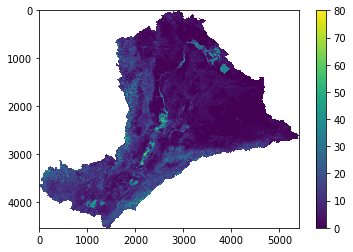

In [12]:
Array = Subdataset.ReadAsArray().astype(np.float32) # قراءة مجموعة البيانات الفرعية كمصفوفة رقمية
Array[Array == NDV] = np.nan # استبدل لا توجد قيمة بيانات بقيمة NAN

plt.imshow(Array) # مخطط مجموعة كصورة
plt.colorbar()
plt.show()

<div dir="rtl">
عادة ، يكون العقد 10 أيام ماعدا آخر عقد من الشهر. على سبيل المثال ، يمكن أن يحتوي آخر عقد في فبراير على 8 أو 9 أيام ، أما آخر عقد في يناير فيمكن أن يحتوي على 11 يومًا. يمكن حساب عدد الأيام في فترة البيانات النقطية عند معرفة تاريخ البدء والانتهاء. تذكر أنه في التمرين السابق ، يمكننا الحصول على هذه المعلومات باستخدام وظيفة الحزمة hkvwaporpy get_data_availity. أدناه يمكنك أن ترى أن كل raster_id له يوم بداية ونهاية.    
</div>

In [13]:
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')
df_avail.head()

data_avail_period: DEKAD


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0111,0120,L2_AETI_0902,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0121,0131,L2_AETI_0903,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0201,0210,L2_AETI_0904,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0211,0220,L2_AETI_0905,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."


<div dir="rtl">
يمكننا الوصول إلى هذه المعلومات واستخدامها لحساب عدد الأيام في فترة البيانات النقطية. فيما يلي مثال على كيفية الحصول على عدد الأيام في الفترة النقطية الأولى في قائمة البيانات المتاحة df_avail. يمكنك محاولة تعديل التعليمات البرمجية لإجراء نفس الحساب لفترات خطوط المسح الأخرى.    
</div>

In [14]:
raster_id=os.path.basename(in_fh).split('.')[0] # احصل على معرف نقطي من اسم الملف
print(raster_id)
raster_info=df_avail.loc[df_avail['raster_id']==raster_id] # اقرأ الفترة المقابلة لمعرف البيانات النقطية
raster_info

L2_AETI_0901


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."


<div dir="rtl">
حساب عدد الأيام في عقد من خطوط المسح. هنا ، raster_info ['start_dekad'] من نوع سلسلة لذا يجب تحويلها إلى رقم صحيح للحساب. ناتج خلية الشفرة أدناه هو عدد أيام العقد النقطية    
</div>

In [15]:
start=int(raster_info['start_dekad'].iloc[0]) 
end=int(raster_info['end_dekad'].iloc[0])
ndays=end-start+1
ndays

10

<div dir="rtl">
مجرد حصولنا على معلومات مضاعف عامل التحويل وعدد الأيام ، يمكننا تصحيح البيانات الأولية في مجموعة الخرائط النقطية بضرب النسق المفتوح بهاتين القيمتين. انظر المثال أدناه.    
</div>

multiplier: 0.1
number of days: 10


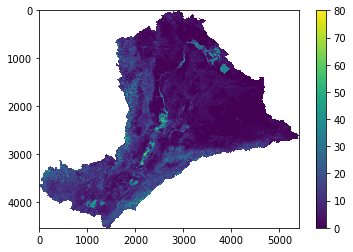

In [18]:
print('المضاعف: {0}'.format(multiplier))
print('عدد الأيام: {0}'.format(ndays))
CorrectedArray=Array*multiplier*ndays
plt.imshow(CorrectedArray)
plt.colorbar()
plt.show()

<div dir="rtl">
لاحظ أن القيمة في شريط اللون لا تتغير لأن المصفوفة مضروبة بـ 0.1 و 10. إذا كان عدد الأيام مختلفًا عن 10 ، فإن القيمة الجديدة بـ mm / dekad ستكون مختلفة عن متوسط العقد اليومي mm / day. لحفظ نتيجتنا كملف نقطي (GeoTIFF) ، نحتاج إلى معرفة خصائص الملف النقطي الأصلي (برنامج التشغيل ، قيمة Nodata ، الحجم ، المدى ، الإسقاط). يوجد أدناه مثال لحفظ المصفوفة المصححة أعلاه كملف نقطي جديد. أولاً، يتم تحديد اسم ملف الإخراج ويتم إنشاء مجلد الإخراج إذا لم يكن موجودًا.    
</div>

In [21]:
output_folder=r'.\data\L2_AETI_D_corrected'
if not os.path.exists(output_folder): # تحقق مما إذا كان output_folder موجودًا
    os.makedirs(output_folder) # إذا لم تقم بإنشاء ملف output_folder
out_fh=os.path.join(output_folder,raster_id+'.tif') # يتم تحديد مسار ملف الإخراج
print(out_fh)

.\data\L2_AETI_D_corrected\L2_AETI_0901.tif


<div dir="rtl">
ثم يتم حفظ قيمة CorrectedArray كـ out_fh في مجلد الإخراج (data/L2_AETI_D_corrected) باستخدام الرموز أدناه    
</div>

[مجلد الإخراج](data/L2_AETI_D_corrected)

In [20]:
datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32']) # إنشاء مجموعة بيانات من برنامج التشغيل
DataSet.GetRasterBand(1).SetNoDataValue(NDV) # تعيين قيمة Nodata لمجموعة البيانات الجديدة
DataSet.SetGeoTransform(GeoT)# تعيين التحول الجغرافي
DataSet.SetProjection(Projection.ExportToWkt()) 
DataSet.GetRasterBand(1).WriteArray(CorrectedArray) # اكتب قيم CorrectedArray إلى مجموعة البيانات الجديدة
print(out_fh)

.\data\L2_AETI_D_corrected\L2_AETI_0901.tif


<div dir="rtl">

###  2 تمرين    
    
</div>

<div dir="rtl">
قم بتصحيح جميع بيانات AETI و E و T و I العقدية التي تم تنزيلها من دفتر الملاحظات السابق (1_Download_WaPOR_using_hkvwaporpy.ipynb) التمرين 1 مع مضاعف وعدد الأيام في dekad.    
</div>

[دفتر الملاحظات السابق](1_Download_WaPOR_using_hkvwaporpy.ipynb)

<div dir="rtl">
ملحوظة:
  استفد من الوظائف في الأمثلة. يمكنك استخدام حلقة for-loop. يمكنك إنشاء وظيفتك الخاصة باستخدام def لإعادة استخدامها لاحقً    
</div>

**def** Function(Inputs):

    Do something with Inputs #افعل شيئًا باستخدام المدخلات
    
    return Output

In [22]:
import hkvwaporpy as hkv
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetGeoInfo(fh, subdataset = 0):
    '''
    تستخرج هذه الوظيفة البيانات الوصفية من ملف GeoTIFF أو HDF4 أو netCDF.      
    ''' 
    '''
    اكتب الكود الخاص بك هنا
    ''' 
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    '''
    تقرأ هذه الوظيفة ملف GeoTIFF أو HDF4 كمصفوفة numpy.
    ''' 
    '''
    اكتب الكود الخاص بك هنا
    ''' 
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, 
                  Projection, explicit = True, compress = None):      
    '''
    تقوم هذه الوظيفة بحفظ مصفوفة numpy كملف GeoTIFF نقطي.
    ''' 
    '''
    اكتب الكود الخاص بك هنا
    ''' 

<div dir="rtl">
بعد إكمال وتحديد الوظائف المذكورة أعلاه ، يمكنك إعادة استخدامها في الكود أدناه لتصحيح بيانات dekadal AETI    
</div>

In [24]:
df=hkv.read_wapor.get_catalogus()
ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2009-01-01,2009-12-31]')

### احصل على المضاعف
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]

### الحصول على البيانات النقطية
input_folder=r'.\data\L2_AETI_D'
input_fhs=sorted(glob.glob(input_folder+'\*.tif'))

output_folder=r'.\data\L2_AETI_D_corrected'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
### احصل على GeoInfo
in_fh=input_fhs[0]
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(in_fh)

### الحساب
for in_fh in input_fhs:
    ### احصل على عدد الأيام في الفترة النقطية
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=int(raster_info['start_dekad'].iloc[0])
    end=int(raster_info['end_dekad'].iloc[0])
    ndays=end-start+1
    ### تصحيح البيانات النقطية مع المضاعف وعدد الأيام
    Array=OpenAsArray(in_fh,nan_values=True)
    CorrectedArray=Array*multiplier*ndays
    ### حفظ مجموعة مصححة
    out_fh=os.path.join(output_folder,raster_id+'.tif')
    CreateGeoTiff(out_fh, CorrectedArray, driver, NDV, xsize, ysize, GeoT, Projection)
    print(out_fh)

data_avail_period: DEKAD
.\data\L2_AETI_D_corrected\L2_AETI_0901.tif
.\data\L2_AETI_D_corrected\L2_AETI_0902.tif
.\data\L2_AETI_D_corrected\L2_AETI_0903.tif
.\data\L2_AETI_D_corrected\L2_AETI_0904.tif
.\data\L2_AETI_D_corrected\L2_AETI_0905.tif
.\data\L2_AETI_D_corrected\L2_AETI_0906.tif
.\data\L2_AETI_D_corrected\L2_AETI_0907.tif
.\data\L2_AETI_D_corrected\L2_AETI_0908.tif
.\data\L2_AETI_D_corrected\L2_AETI_0909.tif
.\data\L2_AETI_D_corrected\L2_AETI_0910.tif
.\data\L2_AETI_D_corrected\L2_AETI_0911.tif
.\data\L2_AETI_D_corrected\L2_AETI_0912.tif
.\data\L2_AETI_D_corrected\L2_AETI_0913.tif
.\data\L2_AETI_D_corrected\L2_AETI_0914.tif
.\data\L2_AETI_D_corrected\L2_AETI_0915.tif
.\data\L2_AETI_D_corrected\L2_AETI_0916.tif
.\data\L2_AETI_D_corrected\L2_AETI_0917.tif
.\data\L2_AETI_D_corrected\L2_AETI_0918.tif
.\data\L2_AETI_D_corrected\L2_AETI_0919.tif
.\data\L2_AETI_D_corrected\L2_AETI_0920.tif
.\data\L2_AETI_D_corrected\L2_AETI_0921.tif
.\data\L2_AETI_D_corrected\L2_AETI_0922.tif
.\data\

## Step 3. Aggregate monthly data

<div dir="rtl">
الخطوة 3. تجميع البيانات الشهرية    
</div>

<div dir="rtl">    

### مثال
    
</div>    

<div dir="rtl">
لاحظ أن البيانات الشهرية متوفرة فقط في إصدارات WaPOR 2 بينما الإصدار 1 يحتوي فقط على بيانات عقدية وسنوية. في هذه الحالة ، يمكنك تجميع العقد لحساب البيانات الشهرية. لتحويل البيانات العقدية أو اليومية إلى بيانات شهرية ، سنجمع جميع البيانات في الخرائط النقطية العقدية في الشهر. أولاً ، سنحصل على قائمة بكل شهور وسنوات البيانات المتوفرة لدينا. على سبيل المثال ، يوجد أدناه رمز للحصول على قائمة بالشهر والسنة التي يجب حسابها.    
</div>

In [26]:
start_date='2009-01-01'
end_date='2009-12-31'
month_dates=pd.date_range(start_date,end_date,freq='M')
for date in month_dates:
    print(date.year,date.month)

2009 1
2009 2
2009 3
2009 4
2009 5
2009 6
2009 7
2009 8
2009 9
2009 10
2009 11
2009 12


<div dir="rtl">
الآن ، عندما ننظر إلى قائمة البيانات العقدية التي لدينا. تم استخدام raster_id لتسمية الملف النقطي في التمرين السابق. يحتوي هذا raster_id فقط على السنة ومؤشر dekad (من 1 إلى 36).    
</div>

In [27]:
input_folder=r'.\data\L2_AETI_D_corrected'
input_fhs=sorted(glob.glob(input_folder+'\*.tif'))

ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

for in_fh in input_fhs:
    print(in_fh)

data_avail_period: DEKAD
.\data\L2_AETI_D_corrected\L2_AETI_0901.tif
.\data\L2_AETI_D_corrected\L2_AETI_0902.tif
.\data\L2_AETI_D_corrected\L2_AETI_0903.tif
.\data\L2_AETI_D_corrected\L2_AETI_0904.tif
.\data\L2_AETI_D_corrected\L2_AETI_0905.tif
.\data\L2_AETI_D_corrected\L2_AETI_0906.tif
.\data\L2_AETI_D_corrected\L2_AETI_0907.tif
.\data\L2_AETI_D_corrected\L2_AETI_0908.tif
.\data\L2_AETI_D_corrected\L2_AETI_0909.tif
.\data\L2_AETI_D_corrected\L2_AETI_0910.tif
.\data\L2_AETI_D_corrected\L2_AETI_0911.tif
.\data\L2_AETI_D_corrected\L2_AETI_0912.tif
.\data\L2_AETI_D_corrected\L2_AETI_0913.tif
.\data\L2_AETI_D_corrected\L2_AETI_0914.tif
.\data\L2_AETI_D_corrected\L2_AETI_0915.tif
.\data\L2_AETI_D_corrected\L2_AETI_0916.tif
.\data\L2_AETI_D_corrected\L2_AETI_0917.tif
.\data\L2_AETI_D_corrected\L2_AETI_0918.tif
.\data\L2_AETI_D_corrected\L2_AETI_0919.tif
.\data\L2_AETI_D_corrected\L2_AETI_0920.tif
.\data\L2_AETI_D_corrected\L2_AETI_0921.tif
.\data\L2_AETI_D_corrected\L2_AETI_0922.tif
.\data\

<div dir="rtl">
لذلك ، سوف نستخدم raster_id هذا للحصول على شهر dekad من df_avail dataframe. تذكر من التمرين السابق استخدمنا start_dekad و end_dekad لحساب عدد الايام في العقد؟ يمكننا أيضًا استخدام هذا للتحقق مما إذا كان مؤشر dekad ينتمي إلى الشهر الذي نريد حساب القيمة الإجمالية باستخدام شرط if. على سبيل المثال ، الشهر الذي نريد حساب القيمة الإجمالية هو الشهر الأول من القائمة (date = month_dates[0]). نقوم بعمل حلقة فوق جميع الملفات النقطية ونتحقق مما إذا كان الشهر والسنة اللذين ينتمي إليهما متماثلان مع الشهر والسنة اللذين نريد حسابهما.    
</div>

**if** (year==date.year)&(month==date.month):

    month_fhs.append(in_fh)


<div dir="rtl">
    
إذا كان هذا صحيحًا ، فسيتم إضافة معالج الملف النقطي إلى قائمة معالجات الملفات التي تنتمي إلى الشهر المعني. على سبيل المثال ، تحصل الشفرة أدناه على قائمة بمعالجات الملفات النقطية الخاصة بـ dekads تنتمي إلى الشهر الأول من عام 2009.    
</div>

In [28]:
date=month_dates[0]
print(date)
month_fhs=[]
for in_fh in input_fhs:
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=raster_info['start_dekad'].iloc[0]
    year=raster_info.index.values.astype(int)[0]
    month=int(start[0:2])
    if (year==date.year)&(month==date.month):
        month_fhs.append(in_fh)
print(month_fhs)

2009-01-31 00:00:00
['.\\data\\L2_AETI_D_corrected\\L2_AETI_0901.tif', '.\\data\\L2_AETI_D_corrected\\L2_AETI_0902.tif', '.\\data\\L2_AETI_D_corrected\\L2_AETI_0903.tif']


<div dir="rtl">
لإضافة البيانات من النقطيات الثلاثة ، نقوم بإنشاء مصفوفة أصفار ثنائية الأبعاد بنفس الحجم باستخدام النقطيات الثلاثة باستخدام np.zeros ثم اقرأ كل نقطية كمصفوفة وأضف القيمة إلى مجموعة الأصفار هذه. يوجد أدناه مثال لحساب SumArray    
</div>

.\data\L2_AETI_D_corrected\L2_AETI_0901.tif
5406 4529


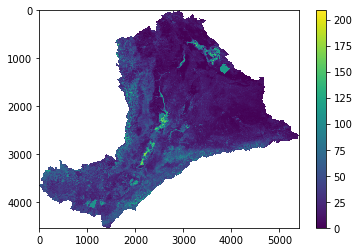

In [29]:
print(input_fhs[0])
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(input_fhs[0])
print(xsize,ysize)
SumArray=np.zeros((ysize,xsize))
for fh in month_fhs:
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
plt.imshow(SumArray)
plt.colorbar()
plt.show()

<div dir="rtl">
باستخدام وظيفة Create GeoTiff التي تم تحديدها من قبل ، يمكننا حفظ Sum Array كبيانات نقطية شهرية    
</div>

In [30]:
output_folder=r'.\data\L2_AETI_M'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
out_fh=os.path.join(output_folder,'AETI_{:04d}{:02d}.tif'.format(date.year,date.month))
print(out_fh)
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

.\data\L2_AETI_M\AETI_200901.tif


<div dir="rtl">
باستخدام حلقة for-loop للتكرار على مدار جميع تواريخ الشهر لعام 2009 ، يمكننا تجميع البيانات النقطية الشهرية من جميع بيانات dekadal النقطية التي تم تنزيلها. سيتم حفظ الملفات الناتجة في مجلد الإخراج L2_AETI_M (data/L2_AETI_M)    
</div>

[L2_AETI_M](data/L2_AETI_M)

In [31]:
for date in month_dates:
    month_fhs=[]
    for in_fh in input_fhs:
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        start=raster_info['start_dekad'].iloc[0]
        year=raster_info.index.values.astype(int)[0]
        month=int(start[0:2])
        if (year==date.year)&(month==date.month):
            month_fhs.append(in_fh)
    SumArray=np.zeros((ysize,xsize))
    for fh in month_fhs:
        Array=OpenAsArray(fh,nan_values=True)
        SumArray+=Array
    out_fh=os.path.join(output_folder,'AETI_{:04d}{:02d}.tif'.format(date.year,date.month))
    CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

## Step 4. Aggregate data in a period

<div dir="rtl">
الخطوة 4. تجميع البيانات في فترة    
</div>


<div dir="rtl">
في حال أردنا تجميع بيانات dekadal النقطية لفترة مخصصة بدلاً من الشهر (على سبيل المثال ، مواسم المحاصيل) ، يمكننا استخدام خطوات مماثلة. أولاً ، احصل على قائمة بجميع البيانات النقطية المصححة في المجلد    
</div>

In [32]:
input_folder=r'.\data\L2_AETI_D_corrected'
input_fhs=sorted(glob.glob(input_folder+'\*.tif'))
input_fhs

['.\\data\\L2_AETI_D_corrected\\L2_AETI_0901.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0902.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0903.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0904.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0905.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0906.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0907.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0908.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0909.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0910.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0911.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0912.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0913.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0914.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0915.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0916.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0917.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0918.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0919.tif',
 '.\\data\\L2_AETI_D_corrected\

<div dir="rtl">
أنشئ الفترة بتواريخ البدء والانتهاء. على سبيل المثال ، هنا تبدأ الفترة من فبراير إلى أغسطس 2009    
</div>

In [34]:
start_period='2009-02-01'
end_period='2009-08-10'
period_dates=pd.date_range(start_period,end_period,freq='D')
period_dates

DatetimeIndex(['2009-02-01', '2009-02-02', '2009-02-03', '2009-02-04',
               '2009-02-05', '2009-02-06', '2009-02-07', '2009-02-08',
               '2009-02-09', '2009-02-10',
               ...
               '2009-08-01', '2009-08-02', '2009-08-03', '2009-08-04',
               '2009-08-05', '2009-08-06', '2009-08-07', '2009-08-08',
               '2009-08-09', '2009-08-10'],
              dtype='datetime64[ns]', length=191, freq='D')

<div dir="rtl">
بعد ذلك ، سوف نحصل على جدول المعلومات النقطية المتاح لعام 2009 باستخدام وظيفة hkvwaporpy    
</div>

In [35]:
df=hkv.read_wapor.get_catalogus(version='2.0')
ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2009-01-01,2009-12-31]')
df_avail

data_avail_period: DEKAD


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0111,0120,L2_AETI_0902,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0121,0131,L2_AETI_0903,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0201,0210,L2_AETI_0904,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0211,0220,L2_AETI_0905,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0221,0228,L2_AETI_0906,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0301,0310,L2_AETI_0907,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0311,0320,L2_AETI_0908,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."
2009,0321,0331,L2_AETI_0909,EPSG:4326,"[-30.0044643, -40.0044643, 65.0044643, 40.0044..."


<div dir="rtl">
قم بالتمرير على قائمة البيانات النقطية في المجلد وتحقق مما إذا كان تاريخ بداية البيانات النقطية أو نهايتها ينتمي إلى الفترة. إذا كان هذا صحيحًا ، فقم بإلحاق مؤشر الملف النقطي بقائمة period_fhs. القائمة الناتجة سوف تحتوي على ملف نقطي من dekad 0904 (أول dekad من فبراير 2009) إلى dekad 0922 (أول dekad من أغسطس 2009)    
</div>

In [36]:
period_fhs=[]
for in_fh in input_fhs:
    # احصل على معرف نقطي من اسم الملف
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    # الحصول على معلومات نقطية باستخدام معرف البيانات النقطية
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]    
    # الحصول على سلسلة زمنية
    startstr=raster_info['start_dekad'].iloc[0]
    endstr=raster_info['end_dekad'].iloc[0]
    yearstr=raster_info.index[0]
    # الحصول على تاريخ البدء والانتهاء من البيانات النقطية
    raster_startdate=pd.Timestamp(int(yearstr),int(startstr[0:2]),int(startstr[2:4]),0)
    raster_enddate=pd.Timestamp(int(yearstr),int(endstr[0:2]),int(endstr[2:4]),0)
    # تحقق مما إذا كانت البيانات النقطية تنتمي إلى فترة
    if ((raster_startdate in period_dates) or (raster_enddate in period_dates)):
        period_fhs.append(in_fh)   
period_fhs

['.\\data\\L2_AETI_D_corrected\\L2_AETI_0904.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0905.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0906.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0907.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0908.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0909.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0910.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0911.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0912.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0913.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0914.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0915.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0916.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0917.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0918.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0919.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0920.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0921.tif',
 '.\\data\\L2_AETI_D_corrected\\L2_AETI_0922.tif']

<div dir="rtl">
جمع كل مجموعات البيانات النقطية في فترة لتجميع بيانات الفترة.    
</div>

In [37]:
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(period_fhs[0])
SumArray=np.zeros((ysize,xsize))
for fh in period_fhs:
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
out_fh=os.path.join(f'.\data\L2_AETI_{start_period}_{end_period}.tif')
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

## Step 5. Warp raster data

<div dir="rtl">
الخطوة 5. اعوجاج البيانات النقطية
</div>

<div dir="rtl">
  تأتي البيانات المكانية بأحجام ودقة مختلفة ونظام مرجعي مكاني مختلف. على سبيل المثال ، عند فتحها كمصفوفة ، يختلف حجم خرائط الترسيب والبخرنتح الفعلي والاعتراض. يوجد أدناه حجم طبقة خطوط هطول الأمطار.     
</div>


(90, 107)


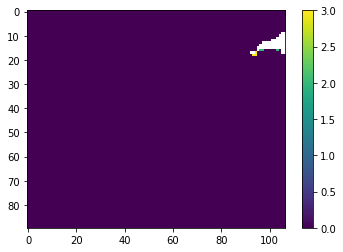

In [38]:
P_fh=r".\data\L1_PCP_E_cropped\L1_PCP_090101.tif"
P=OpenAsArray(P_fh,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

<div dir="rtl">
ويوجد أسفل هذه الخلية حجم طبقة AETI النقطية    
</div>

(4529, 5406)


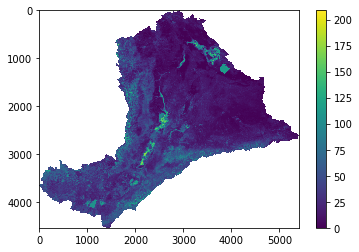

In [39]:
ET_fh=r".\data\L2_AETI_M\AETI_200901.tif"
ET=OpenAsArray(ET_fh,nan_values=True)
print(ET.shape)
plt.imshow(ET)
plt.colorbar()
plt.show()

<div dir="rtl">
كما نرى ، فإن بيانات هطول الأمطار لها دقة أقل (0.5 درجة) ، وبالتالي حجم مصفوفة أصغر (90 × 107) من بيانات AETI (100 متر و 4529 × 5406). بالنسبة لهاتين النقطتين في نفس الحساب ، يجب تحويلهما إلى نفس الحجم والدقة والإسقاط. هنا ، نستخدم خريطة استخدام الأراضي كقالب لتشويه هذه البيانات في نفس النموذج.
</div>

<div dir="rtl">
يمكن القيام بذلك باستخدام دالة gdal.Warp ووظيفة فسيفساء للصورة وإعادة إسقاط وتزييف. يتم استخدام gdal.Warp لتشويه البيانات النقطية المحددة لحجم البيانات المحددة مسبقًا والمدى المكاني ، وإعادة إسقاطها إلى نظام الإسناد المكاني المحدد مسبقًا. الى gdal. قم بلف ملف نقطي لمطابقة الإسقاط والحجم والمدى مع ملف نقطي آخر ، يجب الحصول على معلومات الملف الهدف أولاً. الوظيفة التالية هي الحصول على قيمة nodata ونظام الإسناد المكاني وحجم البيانات والمدى المكاني لملف نقطي باستخدام حزمة gdal.
</div>

<div dir="rtl">
على سبيل المثال ، هنا الملف النقطي لخريطة AETI هو الملف الهدف. نريد مطابقة الإسقاط والحجم ومدى الملف المصدر، وهو هطول الأمطار، مع الملف الهدف.    
</div>

In [41]:
src_info=gdal.Info(gdal.Open(P_fh),format='json')
dst_info=gdal.Info(gdal.Open(ET_fh),format='json')

print('Source info: ',src_info,'\n')

print('Target info: ',dst_info)

Source info:  {'description': '.\\data\\L1_PCP_E_cropped\\L1_PCP_090101.tif', 'driverShortName': 'GTiff', 'driverLongName': 'GeoTIFF', 'files': ['.\\data\\L1_PCP_E_cropped\\L1_PCP_090101.tif'], 'size': [107, 90], 'coordinateSystem': {'wkt': 'GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID["WGS 84",6378137,298.257223563,\n            AUTHORITY["EPSG","7030"]],\n        AUTHORITY["EPSG","6326"]],\n    PRIMEM["Greenwich",0],\n    UNIT["degree",0.0174532925199433],\n    AUTHORITY["EPSG","4326"]]'}, 'geoTransform': [37.95000000000002, 0.05, 0.0, 12.4, 0.0, -0.05], 'metadata': {'': {'AREA_OR_POINT': 'Area'}, 'IMAGE_STRUCTURE': {'INTERLEAVE': 'BAND'}}, 'cornerCoordinates': {'upperLeft': [37.95, 12.4], 'lowerLeft': [37.95, 7.9], 'lowerRight': [43.3, 7.9], 'upperRight': [43.3, 12.4], 'center': [40.625, 10.15]}, 'wgs84Extent': {'type': 'Polygon', 'coordinates': [[[37.95, 12.4], [37.95, 7.9], [43.3, 7.9], [43.3, 12.4], [37.95, 12.4]]]}, 'bands': [{'band': 1, 'block': [107, 19], 'type': 

<div dir="rtl">
بعد الحصول على src_info من المصدر ومعلومات الهدف dst_info ، يمكننا إملاء هذه المعلومات إلى gdal.Warp على النحو التالي. إذا كان gdal. انتهى من وظيفة الالتفاف بنجاح، ستقوم بإرجاع كائن osgeo.gdal.Dataset وسيتم حفظ الملف النقطي الناتج في مجلد الإخراج (data/L1_PCP_E_warped)    
</div>

[مجلد الإخراج](data/L1_PCP_E_warped)

In [42]:
source_file=P_fh
output_folder=r'.\data\L1_PCP_E_warped'
if not os.path.exists(output_folder): # إنشاء output_folder إذا لم يكن موجودًا
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) # الحصول على اسم الملف من مسار ملف المصدر
output_file=os.path.join(output_folder,filename) # إنشاء مسار ملف الإخراج

gdal.Warp(output_file,P_fh,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000227C009E690> >

<div dir="rtl">

### التمرين 3
    
</div>

<div dir="rtl">
قم بعمل وظيفة معرّفة من قبل المستخدم لتحويل أي ملف نقطي بنقطية معينة. استخدم هذه الوظيفة لمطابقة الإسقاط والحجم ومدى كل هطول الأمطار مع بيانات ET. 
</div>


In [ ]:
def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    تعمل هذه الوظيفة على تحويل جميع الملفات النقطية في قائمة بنفس الحجم،
    الدقة والإسقاط بملف مصدر نقطي.
    """
    '''
    اكتب رمزك هنا ''
    '''
    return output_files

input_folder=r".\data\L1_PCP_E_cropped"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_E_warped'
MatchProjResNDV(ET_fh, input_fhs, output_folder)

## Step 6. Clip to Shapefile cutline

<div dir="rtl">
الخطوة 6. القص إلى حدود ملف الشكل
</div>

<div dir="rtl">
الخطوة 1 تقوم فقط بقص البيانات النقطية في المربع المحيط. عندما نحتاج إلى استبعاد وحدات البكسل خارج منطقة الاهتمام ، على سبيل المثال ، في حالة الحوض الهيدرولوجي أو كتلة الري ، يمكننا استخدام gdal.Warp مع خيار القطع لقص خطوط المسح إلى حدود المضلع لملف الشكل. انظر المثال أدناه       
</div>

In [44]:
input_fh=r".\data\L1_PCP_E_warped\L1_PCP_090101.tif" # المسار إلى البيانات النقطية المراد قصها
shp_fh=r".\data\Awash_shapefile.shp" # المسار إلى ملف الشكل الذي يحتوي على مضلع المنطقة محل الاهتمام

output_folder=r'.\data\L1_PCP_E_clipped'# مسار لمجلد الإخراج
if not os.path.exists(output_folder): # إنشاء output_folder إذا لم يكن موجودًا
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) # الحصول على اسم الملف من مسار ملف المصدر
output_fh=os.path.join(output_folder,filename) # إنشاء مسار ملف الإخراج

<div dir="rtl">
بعد تحديد الملف النقطي للإدخال والإخراج ومسارات ملف الأشكال ، يمكننا استخدام وظيفة مكتبة ogr لقراءة مجموعة بيانات الشكل ككائن gdal للحصول على اسم الطبقة. بعد ذلك ، استخدم مسار ملف الشكل والطبقة كوسائط خيارات لوظيفة gdal.Warp. تحقق من ملف الإخراج في مجلد الإخراج (data/L1_PCP_E_clipped)    
</div>

[مجلد الإخراج](data/L1_PCP_E_clipped)

In [45]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) # قراءة ملف الشكل كمجموعة بيانات gdal
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

<div dir="rtl">
يوجد أدناه قيمة إدخال البيانات النقطية قبل القطع    
</div>

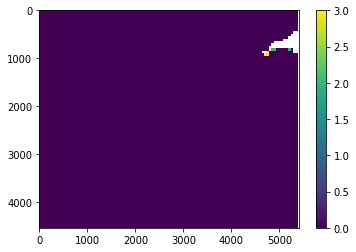

In [50]:
input_array=OpenAsArray(input_fh,nan_values=True)
plt.imshow(input_array)
plt.colorbar()
plt.show()

<div dir="rtl">
وأدناه هي قيمة الناتج النقطي بعد القطع.    
</div>

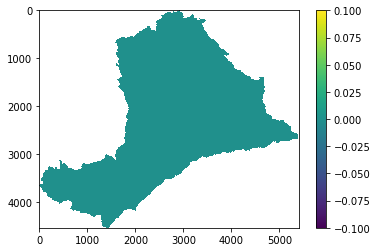

In [51]:
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

<div dir="rtl">
على غرار الخطوة 5 ، يمكننا تحديد وظيفة جديدة وتطبيقها على جميع الملفات المراد قصها.    
</div>

In [52]:
def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    قص خطوط المسح إلى خط الحدود لملف الشكل
    
    المعلمات
    ----------
    input_fhs : list
        قائمة ملفات الإدخال النقطية
    output_folder : str
        المسار إلى المجلد حيث يتم حفظ البيانات النقطية للإخراج
    shp_fh : str
        مجلد لتخزين الإخراج.
    NDV : float or int, optional
        لا توجد قيمة بيانات للمخرجات النقطية
        
    عائدات
    -------
    output_fhs : list 
        مقابض الملفات للملفات التي تم إنشاؤها.
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )
    output_fhs=[]
    for input_fh in input_fhs:
        output_fh=os.path.join(output_folder,os.path.basename(input_fh))
        sourceds = gdal.Warp(output_fh, input_fh, options = options)
        output_fhs.append(output_fh)
    return output_fhs

<div dir="rtl">
باستخدام وظيفة CliptoShp المحددة ، يمكن قص جميع الملفات النقطية في مجلد الإدخال (data\L1_PCP_E_warped) إلى حد المضلع لملف الشكل. سيتم حفظ ملفات الإخراج في مجلد الإخراج (data\L1_PCP_E_clipped).    
</div>

[مجلد الإدخال](data\L1_PCP_E_warped) 

[مجلد الإخراج](data\L1_PCP_E_clipped)


In [53]:
input_folder=r".\data\L1_PCP_E_warped"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_E_clipped'
CliptoShp(input_fhs, output_folder,shp_fh)

['.\\data\\L1_PCP_E_clipped\\L1_PCP_090101.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090102.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090103.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090104.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090105.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090106.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090107.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090108.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090109.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090110.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090111.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090112.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090113.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090114.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090115.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090116.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090117.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090118.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090119.tif',
 '.\\data\\L1_PCP_E_clipped\\L1_PCP_090120.tif',
 '.\\data\\L1_PCP_E_